In [ ]:
!pip install networkx
!pip install torch-geometric
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import matplotlib.pyplot as plt
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
# Load data
data = pd.read_csv("augmented_dataset.csv")
data=data.head(5000)
# Preprocess data
data['User_ID'] = data['User_ID'].astype(str)

# Extract relevant features for distance calculation
features = data[[ 'Required_Bandwidth', 'Allocated_Bandwidth']].values

# Compute Euclidean distances
dist_matrix = euclidean_distances(features)
threshold_distance = np.percentile(dist_matrix, 90)  # Define a threshold for edge inclusion


In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes with attributes
for _, row in data.iterrows():
    G.add_node(row['User_ID'],
               signal_strength=row['Signal_Strength'],
               latency=row['Latency'],
               required_bandwidth=row['Required_Bandwidth'],
               allocated_bandwidth=row['Allocated_Bandwidth'],
               resource_allocation=row['Resource_Allocation'])


In [ ]:
# Add edges based on distance threshold
num_nodes = len(data)
for i in range(num_nodes):
    print(i)
    for j in range(i + 1, num_nodes):
        if dist_matrix[i, j] < threshold_distance:
            G.add_edge(data['User_ID'].iloc[i], data['User_ID'].iloc[j])

# Convert to PyTorch Geometric data
graph_data = from_networkx(G)

# Include feature information in the node features
node_features = data[['Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth','Resource_Allocation']].values
graph_data.x = torch.tensor(node_features, dtype=torch.float)

# Move graph data to GPU
graph_data = graph_data.to(device)

# Confirm that the data is on GPU
print(graph_data)


Streaming output truncated to the last 5000 lines.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
2

<ipython-input-17-f485ca5ac9be>:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label='Signal Strength')


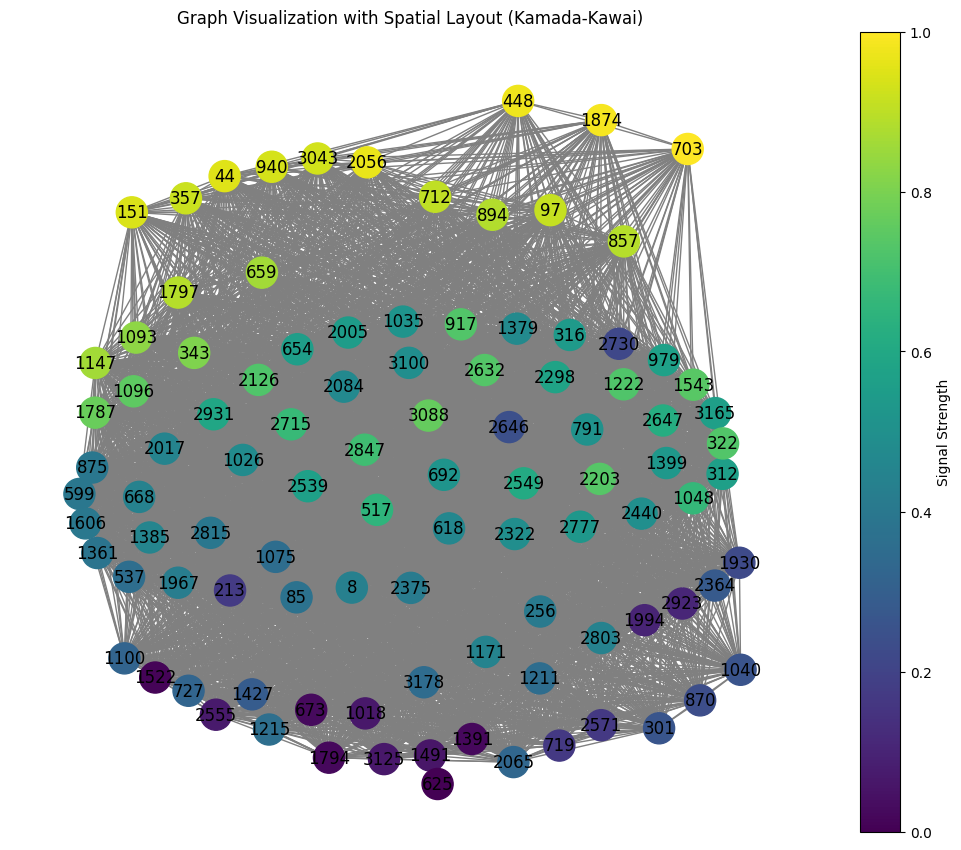

In [ ]:
import matplotlib.pyplot as plt

# Kamada-Kawai Layout
pos = nx.kamada_kawai_layout(G)  # or nx.spectral_layout(G)

# Node color based on any attribute (e.g., Signal_Strength)
node_color = [G.nodes[node]['signal_strength'] for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color=node_color, cmap=plt.cm.viridis, node_size=500, edge_color='gray')
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label='Signal Strength')
plt.title("Graph Visualization with Spatial Layout (Kamada-Kawai)")
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=5, out_channels=32)  # 5 input features
        self.conv2 = GCNConv(in_channels=32, out_channels=64)
        self.fc = torch.nn.Linear(64, 1)  # Predicting a single value (resource allocation)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x.squeeze()


In [ ]:
from sklearn.model_selection import train_test_split

# Extract target variable (resource allocation)
y = data['Resource_Allocation'].values

# Split data into training and testing sets
train_idx, test_idx = train_test_split(range(len(data)), test_size=0.2, random_state=42)

train_mask = torch.zeros(len(data), dtype=torch.bool)
train_mask[train_idx] = True

test_mask = torch.zeros(len(data), dtype=torch.bool)
test_mask[test_idx] = True

# Add masks and target variable to graph data
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask
graph_data.y = torch.tensor(y, dtype=torch.float).to(device)


In [ ]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data)
        loss = criterion(out[graph_data.test_mask], graph_data.y[graph_data.test_mask])
    return loss.item()

for epoch in range(500):
    train_loss = train()
    test_loss = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 0, Train Loss: 263948.8438, Test Loss: 193615.7500
Epoch 10, Train Loss: 7020.1636, Test Loss: 13097.2090
Epoch 20, Train Loss: 8687.3984, Test Loss: 5525.1831
Epoch 30, Train Loss: 3803.5713, Test Loss: 4180.8052
Epoch 40, Train Loss: 189.5480, Test Loss: 72.1162
Epoch 50, Train Loss: 758.5660, Test Loss: 651.1611
Epoch 60, Train Loss: 188.3586, Test Loss: 217.4016
Epoch 70, Train Loss: 68.6690, Test Loss: 69.9993
Epoch 80, Train Loss: 90.7610, Test Loss: 90.1987
Epoch 90, Train Loss: 77.0769, Test Loss: 76.5811
Epoch 100, Train Loss: 66.9833, Test Loss: 73.5657
Epoch 110, Train Loss: 65.4672, Test Loss: 69.0281
Epoch 120, Train Loss: 65.6065, Test Loss: 69.0693
Epoch 130, Train Loss: 65.5808, Test Loss: 69.7651
Epoch 140, Train Loss: 65.4738, Test Loss: 69.0438
Epoch 150, Train Loss: 65.4147, Test Loss: 69.4850
Epoch 160, Train Loss: 65.4403, Test Loss: 69.2433
Epoch 170, Train Loss: 65.4140, Test Loss: 69.3496
Epoch 180, Train Loss: 65.4013, Test Loss: 69.2721
Epoch 190, Train

In [ ]:
model.eval()
with torch.no_grad():
    out = model(graph_data)
    predicted = out[graph_data.test_mask].cpu().numpy()
    actual = graph_data.y[graph_data.test_mask].cpu().numpy()

print('Predicted Resource Allocation:', predicted)
print('Actual Resource Allocation:', actual)


Predicted Resource Allocation: [86.00568   79.90688   86.00568   86.00568   86.005646  80.13798
 86.00568   86.00568   86.00568   86.00568   86.005646  80.082565
 79.643654  86.00568   86.00568   80.40128   86.005646  77.366394
 86.005646  80.686134  80.02277   86.00568   86.00568   78.487465
 77.10953   80.686134  86.00568   86.00568   86.00568   79.96105
 86.00568   79.643654  86.005646  86.00568   78.18219   79.47431
 77.64045   86.005646  78.18219   77.10954   86.005646  86.00568
 79.90688   77.64045   86.00568   86.00568   86.00568   80.25292
 86.00568   86.00568   86.005646  86.00568   86.00568   77.908966
 80.082565  86.00568   86.005646  86.00568   86.00568   86.00568
 86.00568   86.00568   77.36641   80.4013    86.00568   86.00568
 86.00568   86.00568   86.00568   86.00568   86.00568   86.00568
 80.082565  86.00568   86.00568   79.1796    79.90688   86.00568
 79.47428   80.686134  86.00568   86.00568   72.62997   86.00568
 79.90688   86.00568   86.00568   86.00568   86.00568  

In [ ]:
predicted_str = """
86.00568   79.90688   86.00568   86.00568   86.005646  80.13798
 86.00568   86.00568   86.00568   86.00568   86.005646  80.082565
 79.643654  86.00568   86.00568   80.40128   86.005646  77.366394
 86.005646  80.686134  80.02277   86.00568   86.00568   78.487465
 77.10953   80.686134  86.00568   86.00568   86.00568   79.96105
 86.00568   79.643654  86.005646  86.00568   78.18219   79.47431
 77.64045   86.005646  78.18219   77.10954   86.005646  86.00568
 79.90688   77.64045   86.00568   86.00568   86.00568   80.25292
 86.00568   86.00568   86.005646  86.00568   86.00568   77.908966
 80.082565  86.00568   86.005646  86.00568   86.00568   86.00568
 86.00568   86.00568   77.36641   80.4013    86.00568   86.00568
 86.00568   86.00568   86.00568   86.00568   86.00568   86.00568
 80.082565  86.00568   86.00568   79.1796    79.90688   86.00568
 79.47428   80.686134  86.00568   86.00568   72.62997   86.00568
 79.90688   86.00568   86.00568   86.00568   86.00568   86.00568
 86.00568   79.643654  80.47658   86.00568   86.00568   80.686134
 80.252846  80.082565  80.02277   86.00568   86.00568   78.81855
 86.00568   86.00568   86.00568   86.00568   86.00568   86.00568
 86.00568   86.00568   79.90688   86.00568   86.00568   86.00568
 77.640434  86.00568   86.00568   86.00568   86.00568   86.00568
 86.00568   80.082565  83.82303   86.00568   86.00568   72.62997
 78.18219   86.00568   82.95597   86.00568   79.47428   80.686134
 86.00568   80.47658   80.68612   80.60833   79.90685   79.90685
 86.00568   86.00568   86.00568   80.252914  86.00568   79.17962
 80.13796   79.90685   86.00568   86.00568   80.40128   86.00568
 80.686134  77.90894   86.00568   86.00568   86.00568   79.47428
 86.00568   77.36634   86.00568   86.00568   86.00568   77.64045
 86.00568   86.00568   80.476585  79.90685   86.00568   80.082565
 86.00568   77.90894   80.37617   80.686134  78.81854   86.00568
 86.00568   80.37617   86.00568   86.00568   86.00568   79.179634
 80.60833   86.00568   86.00568   86.00568   86.00568   86.00568
 86.00568   79.90685   84.35749   86.00568   79.90685   86.00568
 86.00568   79.64362   80.13796   78.81855   86.00568   86.00568
 86.00568   86.00568   77.640434  79.90685   86.00568   79.47428
 86.00568   80.47658   86.00568   86.00568   86.00568   86.00568
 77.640434  79.90688   86.00568   86.00568   86.00568   80.40127
 86.00568   86.00568   86.00568   86.00568   79.90685   80.02279
 80.13796   86.00568   79.90685   78.81855   80.13796   86.00568
 86.00568   86.00568   78.487495  86.00568   80.3762    86.00568
 86.00568   86.00568   86.00568   77.36636   80.476585  86.00568
 79.47428   86.00568   86.00568   86.005646  86.00568   86.00568
 80.60839   86.00568   86.00568   80.02279   86.00568   86.00568
 79.90685   86.00568   86.00568   86.00568   78.818565  86.005646
 86.00568   86.00568   86.00568   78.18218   86.005646  86.00568
 80.476585  80.476585  86.005646  80.3762    86.00568   77.36636
 86.00568   86.00568   86.00568   86.00568   86.005646  86.00568
 86.00568   86.00568   77.36638   79.90685   86.00568   86.00568
 86.00568   78.818565  86.00568   86.005646  86.00568   80.68612
 79.4743    85.1839    79.96105   80.13795   78.1822    79.90685
 86.00569   77.36638   80.25293   77.64045   80.60833   86.00569
 86.00566   86.00566   86.005646  86.00569   86.00569   86.00569
 86.00569   86.00569   86.00569   80.02277   86.00569   86.00569
 86.00569   80.68612   86.00566   86.00566   86.00566   86.00566
 78.81856   78.818565  86.00566   86.00566   86.00566   86.00566
 80.68612   79.90684   79.90684   79.4743    79.4743    79.90684
 86.00566   86.00566   80.686134  86.00566   80.686134  80.686134
 86.00566   86.00566   79.643654  86.00566   80.3762    86.00566
 86.00566   72.549065  72.20295   72.522705  72.549065  72.62997
 72.59283   72.62997   72.45668   72.20307   72.33854   72.4835
 72.208565  72.59283   72.549065  72.522736  72.549065  72.20295
 72.292564  72.15646   72.37846   72.59283   72.45668   72.522736
 72.26146   72.3285    72.37846   72.3285    72.37846   72.3285
 72.459465  72.59283   72.549065  72.549065  72.37848   72.549065
 72.59283   72.59283   72.33854   72.549065  72.62997   72.59283
 72.54909   72.37848   72.59283   72.350235  72.48349   72.20295
 72.208565  72.54909   72.62997   72.59283   72.30841   72.48349
 72.37846   72.13999   72.37846   72.50567   72.33854   72.350235
 72.31314   72.22962   72.48349   72.33854   72.52274   72.54909
 72.31313   72.350235  72.22962   72.48349   72.15646   72.15646
 72.59281   72.40505   72.59281   72.52274   72.52274   72.59281
 72.31313   72.350235  72.62997   72.378456  72.59281   72.54909
 72.20295   72.48349   72.33854   72.208565  72.22962   72.33854
 72.48349   72.59281   72.40916   72.17291   72.54909   72.350235
 72.62997   72.54909   72.156494  72.52274   72.59281   72.62997
 72.549095  72.62997   72.62997   72.208565  72.52274   72.5953
 72.30841   72.62997   72.549095  72.20295   72.350235  72.549095
 72.62996   72.549095  72.156494  72.62996   72.549095  72.52275
 72.156494  72.33854   72.59283   72.549095  72.31313   72.52275
 72.350235  72.208565  72.52275   72.52275   72.24589   72.430595
 72.59283   72.48347   72.33854   72.48347   72.45668   72.40502
 72.48347   72.40916   72.59283   72.15646   72.29256   72.350235
 72.350235  72.52274   72.261444  72.37846   72.549095  72.549095
 72.3084    72.261444  72.59283   72.45668   72.33854   72.37846
 72.119446  72.22962   72.45668   72.3285    72.57079   72.37846
 72.62996   72.549095  72.350235  72.59283   72.45668   72.52274
 72.59283   72.3285    72.483475  72.59283   72.52274   72.14
 72.52274   72.30837   72.52274   72.20295   72.59283   72.59283
 72.29256   72.22962   72.24589   72.31313   72.52274   72.33854
 72.62997   72.549095  72.45668   72.261444  72.59283   72.261444
 72.483475  72.14      72.52063   72.350204  72.3285    72.22962
 72.59283   72.261444  72.31313   72.549095  72.29256   72.20295
 72.40916   72.62997   72.22962   72.29256   72.37846   72.31313
 72.261444  72.62997   72.33854   72.549095  72.549095  72.37846
 72.430595  72.50564   72.483475  72.59283   72.208565  72.52274
 72.31313   72.14      72.37846   72.59283   72.483475  72.45668
 72.483475  72.33854   72.45668   72.59283   72.35022   72.42687
 72.45668   72.549095  72.45668   72.30837   72.430595  72.37846
 72.37846   72.549095  72.549095  72.40916   72.40916   72.59283
 72.62995   72.430595  72.20295   72.59283   72.59529   72.50564
 72.59529   72.54911   72.379395  72.59283   72.52274   72.45671
 72.62995   72.40503   72.52274   72.54911   72.54911   72.54911
 72.22962   72.338554  72.350235  72.37848   72.52274   72.17291
 72.20295   72.37848   72.483475  72.52274   72.59529   72.45671
 72.20295   72.338554  72.30836   72.59283   72.45671   72.59283
 72.338554  72.483475  72.45945   72.30836   72.37848   72.483475
 72.62995   72.20295   72.350235  72.54911   72.31315   72.20858
 72.20308   72.52274   72.59283   72.31315   86.0057    81.03417
 86.0057    86.0057    86.0057    84.351845  86.0057    86.0057
 86.0057    86.0057    86.0057    86.0057    86.0057    86.0057
 86.0057    84.91663   86.0057    82.69224   82.69224   86.0057
 86.0057    86.0057    86.0057    86.0057    86.0057    86.0057
 86.0057    85.5277    81.03417   86.00565   86.0057    85.52773
 86.0057    86.0057    86.0057    86.0057    82.69224   86.0057
 86.0057    86.0057    86.0057    86.0057    86.0057    82.69224
 86.0057    83.20682   82.05101   86.0057    86.0057    86.0057
 86.0057    86.0057    82.69224   86.0057    86.0057    86.0057
 84.351845  86.0057    82.05101   86.00565   86.0057    86.0057
 86.0057    86.0057    81.62786   86.0057    86.0057    86.0057
 86.0057    86.0057    86.0057    86.0057    85.52769   86.0057
 84.91663   81.62786   86.0057    86.0057    86.0057    86.0057
 86.0057    86.0057    86.0057    86.0057    86.0057    86.0057
 84.91663   86.0057    86.0057    86.0057    86.0057    86.0057
 86.0057    86.0057    81.62786   86.0057    86.0057    86.0057
 86.0057    83.20682   86.0057    86.0057    82.050995  86.0057
 86.0057    83.2068    80.566605  86.0057    86.0057    86.0057
 86.0057    86.0057    86.0057    84.351845  86.0057    83.902
 86.0057    82.69224   86.0057    83.20682   86.0057    84.916664
 86.0057    86.0057    86.0057    86.0057    86.0057    81.62786
 85.52769   86.0057    86.0057    84.916664  86.0057    86.0057
 84.916664  86.0057    86.0057    86.0057    86.0057    86.0057
 86.0057    86.0057    82.69224   86.0057    86.0057    86.0057
 86.0057    85.52769   86.00565   86.0057    86.0057    85.52769
 86.0057    86.0057    86.0057    86.0057    86.0057    86.0057
 86.0057    86.0057    86.0057    86.0057    86.0057    86.0057
 86.0057    86.0057    86.0057    85.52769   82.69225   86.0057
 81.03417   86.0057    86.0057    86.0057    86.0057    86.0057
 86.005714  86.005714  86.005714  83.20682   86.005714  81.03417
 86.00567   86.005714  86.005714  86.005714  86.005714  86.005714
 83.20682   86.005714  86.005714  86.005714  80.566605  86.005714
 86.005714  86.005714  86.005714  86.005714  86.005714  86.005714
 86.005714  86.005714  86.005714  86.005714  86.005714  86.005714
 86.005714  81.62783   86.005714  82.69224   86.005714  86.005714
 86.005714  86.005714  86.00567   86.005714  86.005714  86.005714
 86.005714  86.005714  86.005714  82.050995  86.005714  81.627846
 86.005714  83.20682   86.005714  86.005714  86.005714  86.005714
 86.005714  86.005714  86.005714  82.69224   86.005714  86.005714
 86.005714  86.005714  82.69228   86.005714  86.005714  86.005714
 82.050995  86.005714  86.005714  82.69228   86.00567   86.00567
 86.005714  86.005714  86.005714  82.69228   86.005714  86.005714
 86.005714  86.005714  86.005714  86.005714  86.005714  86.005714
 86.005714  86.005714  80.566605  86.005714  86.005714  86.005714
 86.005714  86.005714  86.005714  82.050995  86.005714  86.00567
 86.00567   86.005714  86.005714  86.005714  86.005714  85.52767
 83.901924  86.005714  86.005714  86.005714  82.050995  84.91665
 86.005714  86.005714  86.005714  86.005714  84.351845  82.69228
 86.005714  86.005714  86.005714  86.005714  86.005714  86.005714
 86.005714  82.050995  81.627846  86.005714  86.005714  86.005714
 86.005714  86.005714  86.005714  86.005714  83.901924  86.005714
 80.566605  86.00567   86.005714  86.005714  86.005714  86.005714
 86.005714  86.005714  77.94705   78.69936   78.099014  76.78092
 76.78092   74.74772   76.25005   74.74772   76.25005   76.78092
 74.74772   78.099014  78.099014  76.25005   75.24723   74.197655
 77.28946   74.197655  75.24723   76.78092   76.78092   75.24723
 76.25005   74.74772   78.69936   75.72621   77.94705   75.24723
 76.25005   74.74772   76.78092   75.72621   77.289444  78.099014
 76.78092   76.78092   74.197655  74.74772    3.5006518 24.05668
 12.013964  13.198458  17.963104  20.339176"""

actual_str = """
 70.885956 75.44886  60.187138 63.384377 75.589005 75.795906 75.870926
 75.05592  82.110275 75.87385  70.69509  75.150505 75.96465  75.929924
 76.626434 75.53937  74.96045  75.856926 74.86255  76.654495 75.934685
 75.652435 75.82792  77.21898  75.2606   70.760155 71.39313  76.659515
 71.03772  76.4898   76.45024  75.770874 75.54568  76.14228  75.50061
 76.90703  76.00698  70.17704  77.507614 77.439285 75.       76.38303
 76.69841  75.62316  71.70529  75.79646  75.954735 78.070305 75.90534
 75.988205 77.4473   72.37493  74.355156 76.565704 75.21601  75.94851
 75.36334  80.7832   74.91361  76.7959   59.960045 71.39744  75.99114
 76.50664  75.63394  75.49341  75.67117  75.55223  76.41166  76.17844
 70.52971  76.97454  75.1593   76.80179  75.359886 77.049225 75.62426
 71.92088  76.986595 77.57678  75.6489   75.61607  75.363266 90.077286
 74.88151  75.90566  76.653336 79.45695  80.19415  75.83813  76.0315
 76.82622  75.781586 75.50812  75.290016 75.75375  76.24136  70.47018
 76.7698   76.121315 69.131165 60.81433  76.90553  76.82776  71.66004
 75.04808  77.65474  76.06726  74.10597  76.51827  76.749245 71.32523
 74.652565 71.898    76.5469   75.07452  75.65901  74.663414 77.76429
 75.70002  71.01995  76.22287  77.70426  70.87731  75.21888  76.54737
 76.24014  74.91761  76.9752   76.32365  70.79546  76.333466 71.16839
 76.25908  70.12282  75.91281  74.74734  75.014084 75.56029  75.
 76.67111  74.794754 80.63902  77.518036 75.30305  75.84493  76.58019
 75.66471  71.117714 61.65945  70.788574 76.41145  76.37495  76.56516
 76.11981  74.807655 82.00691  77.065895 75.00794  75.70487  76.07004
 75.76526  75.36491  76.974655 75.23041  76.250885 76.64937  74.809525
 62.773357 76.90275  75.12155  75.773705 76.43582  74.38017  77.593834
 75.60758  75.66038  80.68123  75.24842  75.57171  70.270325 76.40824
 81.13478  79.19005  76.67881  69.8531   75.       77.38233  70.6397
 76.54138  76.04771  90.953835 71.550064 75.21126  80.76069  76.04827
 70.85869  75.       74.9382   75.37527  81.23406  76.10634  71.55986
 70.66756  77.359924 75.60796  76.108894 75.417725 75.49566  74.37827
 75.94319  75.8283   77.46748  71.19241  76.9991   76.42687  74.933784
 77.25513  75.855515 76.79201  75.75311  75.87969  75.8794   76.77755
 76.27333  75.34572  74.932594 76.89231  76.79421  76.539665 75.564766
 75.61243  76.623795 75.81052  76.31329  76.530396 76.59517  77.45002
 76.70525  75.967476 76.848976 76.118614 76.13797  75.48025  69.863266
 76.51943  75.52164  75.764626 77.092766 74.78021  71.7756   76.140305
 76.19267  75.313225 75.49311  76.06429  75.82659  76.36318  91.21811
 75.37453  75.15549  76.050934 76.75425  78.2995   74.37457  71.27237
 76.71072  76.04405  59.495396 74.79482  75.77471  77.07319  75.42552
 76.30198  81.10338  75.51403  69.18134  70.19187  75.       76.433525
 75.892975 81.01443  76.43082  75.55552  76.373    76.61973  76.37887
 76.50531  76.48983  76.24448  80.       75.53182  76.2507   75.86339
 76.13074  71.57673  76.48593  75.45432  75.829315 75.14758  76.46785
 75.97399  76.065796 75.37859  76.09599  76.08571  75.22444  77.131165
 76.03665  76.11412  71.64755  70.36744  76.11582  76.66328  76.01659
 76.75258  71.342224 80.58159  77.20729  75.20101  75.222694 76.01742
 75.850075 60.439976 69.85904  76.68743  75.98933  68.45181  90.
 75.14806  75.47293  75.5868   75.48389  75.44637  70.883804 71.18115
 77.02555  74.75005  76.873924 75.45451  91.89723  74.37245  75.851746
 76.45259  75.46111  75.90244  82.91634  82.01077  81.63759  79.05167
 80.012856 80.503586 82.018974 80.41051  81.67771  81.69703  80.34749
 80.33682  80.55212  80.27784  80.44151  80.72521  80.29632  82.12886
 81.580025 81.25239  79.93046  81.09625  82.47491  80.48998  81.19558
 81.60652  82.26446  81.31246  80.18324  79.694305 79.70212  81.34504
 81.09405  80.99574  81.11243  81.83187  81.65597  81.59701  80.131714
 79.97124  81.240585 80.97858  79.9524   81.38915  82.31673  79.32201
 80.739105 79.98352  79.57231  82.046135 81.58173  82.3459   81.59209
 80.32223  80.70325  81.12872  80.278465 81.37368  81.368835 81.14321
 81.313805 79.599075 80.41621  80.59099  81.11355  80.65854  79.99147
 81.427734 81.50093  81.352875 80.13108  81.3799   81.29561  81.047646
 79.556694 82.59653  81.54459  79.26033  81.37046  81.672554 81.59002
 80.785866 79.45168  80.91096  81.87919  80.72205  81.01731  80.13286
 81.216286 80.896355 80.37611  80.564285 80.97448  82.11537  81.48366
 80.83936  81.33851  81.03497  80.11038  81.00849  81.93596  81.21208
 82.5541   81.8726   80.22196  79.87184  81.37935  80.71157  79.90449
 78.71191  80.17787  79.76475  80.42479  81.47779  80.77929  80.29435
 81.05885  81.04502  80.74469  81.249    81.201775 80.02915  80.599304
 80.99031  80.98314  81.286606 79.799286 81.86311  79.953636 81.65832
 81.90379  80.78791  80.35319  81.68659  80.946594 81.009476 82.541405
 80.965004 81.52349  80.59527  81.356544 82.33897  80.508484 80.85679
 80.49908  79.867065 81.53764  81.953926 79.758224 79.389404 81.28756
 82.39273  79.94029  82.34122  81.10317  81.68994  80.997536 81.858444
 81.4273   80.27688  80.94324  78.96037  80.27935  80.248184 81.53996
 81.0631   79.975975 80.98825  82.14866  81.491196 80.75549  80.658356
 81.88954  80.305916 80.64809  80.65997  80.22866  80.86083  80.992386
 81.6529   80.38631  81.56067  81.83374  82.11691  80.52211  80.56769
 81.662895 80.59807  82.09985  81.2844   80.08063  80.13814  80.875916
 80.94016  82.29532  80.776855 80.87163  81.18922  82.08146  81.92454
 82.00908  80.36864  81.158165 82.64575  79.99516  80.263245 80.650986
 80.607635 81.78192  81.35121  82.20034  80.49827  80.2568   82.19595
 81.36806  80.12167  80.95088  80.99055  80.72287  81.81503  81.245445
 81.93434  80.879974 79.19483  80.11     81.61307  80.91616  79.781784
 81.051506 81.76748  80.80665  82.6033   79.831604 80.18478  80.245224
 80.39498  80.68     80.230194 80.00646  80.52154  79.98472  82.09512
 79.94433  81.72545  81.72157  80.1436   80.22109  81.07753  80.19669
 82.24622  80.55509  82.01938  81.813576 80.470055 80.13225  81.23693
 83.0352   80.65782  81.96967  80.75659  80.81176  80.95017  81.06636
 80.08732  80.17447  81.474625 80.065315 80.48872  82.1144   81.26725
 80.50477  82.05431  81.10134  80.4517   79.54005  81.33595  79.8265
 80.39229  82.390945 80.75193  80.749435 81.13078  80.98012  80.47283
 81.918015 80.47485  79.86621  80.14184  81.701454 81.70268  78.666016
 83.18056  80.93212  82.21211  81.132866 80.95148  82.14901  87.44561
 85.6099   86.755775 86.69057  75.11417  86.17146  71.26579  76.32186
 85.560524 85.14138  86.410446 86.97643  85.665886 84.539955 86.407646
 85.39251  85.55414  84.98034  86.81454  86.524605 85.82977  85.99626
 84.79908  85.944305 87.52946  85.17224  86.63558  85.25642  86.51227
 86.15694  85.09151  85.687904 85.3757   86.14302  84.71589  85.709496
 85.375984 87.062294 86.45182  86.44972  85.87877  84.33198  85.410034
 85.614494 86.91638  86.55612  85.66955  85.75526  86.35436  85.28658
 85.78736  84.21785  86.72206  87.21466  86.33196  87.79304  84.82823
 86.65748  85.695595 85.763824 86.54576  85.3364   86.725746 85.30626
 85.747116 86.68563  76.09276  85.75214  86.80577  86.039925 86.0319
 85.66473  84.86948  85.94686  84.72174  86.40801  85.544754 84.858315
 85.86609  86.98846  76.17585  86.57735  84.71172  86.534775 84.74359
 88.33699  85.42136  85.5019   85.64055  84.55287  85.970184 86.59065
 86.312004 86.373055 84.530334 85.91677  87.04394  86.022446 86.715546
 86.5154   86.44722  85.917885 86.08774  86.15354  84.836334 85.6428
 85.91918  85.90338  86.37784  86.9293   85.66099  84.56239  71.11562
 85.26584  86.113304 85.       86.1456   87.28909  84.87693  86.59594
 86.22862  84.52222  85.60737  86.25245  87.47725  85.37769  87.27404
 84.494194 87.18356  86.846    87.26732  85.53994  85.10852  85.51284
 84.591255 85.92156  85.97058  86.55809  85.38278  86.77939  86.570816
 84.9554   87.20632  87.00933  86.480515 85.20799  86.08078  85.27943
 85.5284   85.69548  87.099396 85.15111  87.19626  86.501854 85.969696
 87.11022  85.       84.895134 86.569374 86.06687  85.       86.54422
 85.47964  86.00091  84.90029  85.991905 75.25722  85.115036 86.189644
 85.471176 85.600266 85.44941  86.128716 84.11902  85.64265  86.61044
 84.67893  86.6333   86.03328  85.45617  85.80957  87.51348  86.30488
 86.20767  85.204636 71.75508  87.37486  86.686485 85.41032  85.67791
 86.145836 86.78794  85.49791  86.124054 86.73345  86.44905  86.451935
 86.07496  85.67262  87.77108  85.46966  87.00482  76.43018  86.069016
 86.21237  86.26146  86.04263  85.15595  85.36443  86.45813  85.41058
 85.612816 86.37549  86.8909   86.07788  87.52165  86.2741   86.49114
 86.30358  87.307396 85.5244   86.69673  85.42888  85.65177  87.19839
 85.86124  85.975945 85.90247  76.5415   86.73412  86.2436   86.52649
 86.19674  86.341194 86.66525  86.78294  87.73244  86.86349  86.54515
 86.55771  86.85735  86.042366 86.34236  86.29128  85.79188  76.48783
 85.33908  86.36182  85.1675   70.4419   86.99553  85.06652  87.31229
 86.10171  86.21205  85.20715  88.46464  86.74311  84.63466  85.59078
 86.35014  85.62447  87.1855   87.20445  86.27718  85.32668  85.3607
 86.12405  85.92025  86.607025 86.16375  86.54725  85.67429  85.26051
 85.35666  86.33094  85.84213  85.88315  85.32471  86.82087  85.347336
 87.24179  84.4947   85.268715 87.10873  87.65129  87.40811  85.767235
 86.4177   75.28226  85.76736  86.00717  85.80856  86.572815 87.077415
 86.33741  85.731575 84.9688   86.25954  86.00129  87.55676  85.
 86.87787  87.28714  86.0635   86.22838  84.95753  86.333336 85.45855
 87.02133  87.46095  86.14555  86.09433  87.07179  86.85563  85.77327
 86.14327  86.00602  86.437996 86.11715  72.24489  69.51693  70.143936
 71.41673  71.8532   71.38202  71.070724 70.30942  70.54464  70.4392
 71.856804 71.3507   71.49905  70.62843  71.53579  72.68498  70.97448
 70.672264 69.917    70.94148  70.97641  81.21367  70.68566  72.060524
 70.63826  71.46175  72.161995 70.41288  70.671295 70.7677   70.46044
 70.65185  72.21501  71.664566 69.54932  71.99054  69.300865"""

In [ ]:
# Convert to lists of floats
predicted = [float(x) for x in predicted_str.split()]
actual = [float(x) for x in actual_str.split()]

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score



# Calculate metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(actual) - np.array(predicted)) / np.array(actual))) * 100
r_squared = r2_score(actual, predicted)

# Print metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')
print(f'R-squared: {r_squared}')

# Since F1 Score is usually for classification, it may not be appropriate here,
# but if you still want to calculate it, you could convert the regression output to binary classification.
# Here's an example based on a threshold:
threshold = np.mean(actual)  # For example, use the mean of actual values as a threshold
predicted_binary = [1 if x >= threshold else 0 for x in predicted]
actual_binary = [1 if x >= threshold else 0 for x in actual]

f1 = f1_score(actual_binary, predicted_binary)
print(f'F1 Score: {f1}')


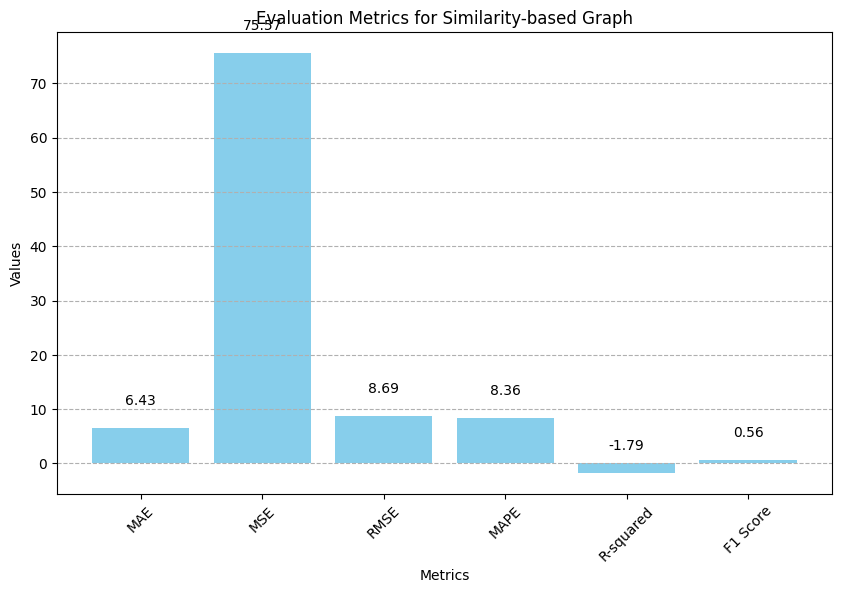

In [3]:
import matplotlib.pyplot as plt

# Updated metrics data
metrics = {
    'MAE': 6.434198542200001,
    'MSE': 75.56815724259519,
    'RMSE': 8.692994722337936,
    'MAPE': 8.356043355480713,
    'R-squared': -1.7944915984057026,
    'F1 Score': 0.5580985915492958
}

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics for Similarity-based Graph')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Add value labels on top of the bars
for i, v in enumerate(metrics.values()):
    plt.text(i, v + (max(metrics.values()) * 0.05), f'{v:.2f}', ha='center', va='bottom')
# Show plot
plt.show()
